<a href="https://colab.research.google.com/github/amanteur/TDA_Cover_detection/blob/main/TDA_CoverDetection_3_Topological_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary

We have:
1. full audio
  1. all features
    1. data_persistence
    2. sparse_data_persistence
    3. persistence_DTM
  2. tonnetz features
    4. data_persistence	
    5. sparse_data_persistence
    6. sparse_data_optimized_persistence
    7. persistence_DTM
  3. mfcc features
    8. data_persistence
    9. sparse_data_persistence
    10. persistence_DTM
2. 60s audio
  1. all features
    11. data_persistence
    12. persistence_DTM
  2. tonnetz features
    13. data_persistence	
    14. data_optimized_persistence
    15. persistence_DTM
  3. mfcc features
    16. data_persistence
    17. persistence_DTM

So, we need to evaluate metrics on 17 types of persistence diagrams


#Libraries

In [ ]:
!pip install gudhi

     |████████████████████████████████| 28.2MB 152kB/s 


In [ ]:
import gudhi as gd
import numpy as np
import gudhi.representations
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Extracting data

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/CourseWork/persistence_datasets/'

In [ ]:
df_as = pd.read_json(root_dir + 'all_short.json')
df_ts = pd.read_json(root_dir + 'tonnetz_short.json')
df_ms = pd.read_json(root_dir + 'mfcc_short.json')

In [ ]:
df_af = pd.read_json(root_dir + 'all_full.json')
df_tf = pd.read_json(root_dir + 'tonnetz_full.json')
df_mf = pd.read_json(root_dir + 'mfcc_full.json')

#Creating 17 datasets

In [ ]:
# 1. all features
#     1. data_persistence
#     2. sparse_data_persistence
#     3. persistence_DTM
df_1 = df_af[['name', 'data_persistence']]
df_2 = df_af[['name', 'sparse_data_persistence']]
df_3 = df_af[['name', 'persistence_DTM']]

# 2. tonnetz features
#     4. data_persistence	
#     5. sparse_data_persistence
#     6. sparse_data_optimized_persistence
#     7. persistence_DTM
df_4 = df_tf[['name', 'data_persistence']]
df_5 = df_tf[['name', 'sparse_data_persistence']]
df_6 = df_tf[['name', 'sparse_data_optimized_persistence']]
df_7 = df_tf[['name', 'persistence_DTM']]

# 3. mfcc features
#     8. data_persistence
#     9. sparse_data_persistence
#     10. persistence_DTM
df_8 = df_mf[['name', 'data_persistence']]
df_9 = df_mf[['name', 'sparse_data_persistence']]
df_10 = df_mf[['name', 'persistence_DTM']]

# 1. all features
#     11. data_persistence
#     12. persistence_DTM
df_11 = df_as[['name', 'data_persistence']]
df_12 = df_as[['name', 'persistence_DTM']]

# 2. tonnetz features
#   13. data_persistence	
#   14. data_optimized_persistence
#   15. persistence_DT

df_13 = df_ts[['name', 'data_persistence']]
df_14 = df_ts[['name', 'data_optimized_persistence']]
df_15 = df_ts[['name', 'persistence_DTM']]

# 3. mfcc features
#     16. data_persistence
#     17. persistence_DTM

df_16 = df_ms[['name', 'data_persistence']]
df_17 = df_ms[['name', 'persistence_DTM']]

In [ ]:
df_dict = {'af_orig':df_1, 
           'af_sparse':df_2, 
           'af_DTM': df_3, 
           'tf_orig': df_4,
           'tf_sparse': df_5, 
           'tf_sparse_opt': df_6, 
           'tf_DTM': df_7, 
           'mf_orig':df_8, 
           'mf_sparse':df_9, 
           'mf_DTM': df_10,  
           'as_orig': df_11, 
           'as_DTM': df_12,
           'ts_orig': df_13, 
           'ts_opt': df_14,
           'ts_DTM': df_15,
           'ms_orig': df_16,
           'ms_DTM': df_17}

#Adding topological features

In [ ]:
def data_preprocessing(data):
  data_scaled = gdr.DiagramSelector(use=True, point_type="finite").fit_transform(data)
  data_scaled = gdr.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(data_scaled)
  data_scaled = gdr.ProminentPoints(use=True, num_pts=25).fit_transform(data_scaled)
  return data_scaled

In [ ]:
import gudhi.representations as gdr

def get_tda_features(df, preprocess=True):
  
  feature_dict = {}
  df_size = df.shape[0]

  for index, row in df.iterrows():

    #diagrams second dimension
    arr = np.array(row[1])
    
    #problem with infinity in dim0 for DTM filtration
    if 'persistence_DTM' in df.columns:
      arr = arr[:-1]

    diag = [arr]
    #preprocessing
    if preprocess:
      diag = data_preprocessing(diag)
    
    #adding to dict
    feature_dict.setdefault(index, {})
    #features
    ##landscapes
    LS = gd.representations.Landscape(resolution=500)
    ls = LS.fit_transform(diag)[0][:500].reshape(1,-1)
    feature_dict[index]['Landscape'] = ls


    ##silhouettes
    SH = gd.representations.Silhouette(resolution=500, weight=lambda x: np.power(x[1]-x[0],1))
    sh = SH.fit_transform(diag)
    feature_dict[index]['Silhouette'] = sh

    ##Entropy
    ###vector
    ET = gdr.Entropy(mode="vector", normalized=False, resolution=500)
    et_v = ET.fit_transform(diag)[0].reshape(1,-1)
    feature_dict[index]['Entropy_vector'] = et_v

    ##Betti curves
    BC = gdr.BettiCurve(resolution=500)
    bc = BC.fit_transform(diag)
    feature_dict[index]['Betti_curves'] = bc
    
    ###scalar
    if 'persistence_DTM' not in df.columns:
      ET = gdr.Entropy(normalized=True)
      et_sc = ET.fit_transform(diag)
      feature_dict[index]['Entropy_scalar'] = et_sc[0]




  dict_df = pd.DataFrame.from_dict(feature_dict).transpose()
  joined_df = df.join(dict_df)

  print('Done!')

  return joined_df

In [ ]:
df_mod_dict = {}

for name, df in df_dict.items():
  print(name)
  df_mod = get_tda_features(df)
  df_mod_dict[name] = df_mod

af_orig
Done!
af_sparse
Done!
af_DTM
Done!
tf_orig
Done!
tf_sparse
Done!
tf_sparse_opt
Done!
tf_DTM
Done!
mf_orig
Done!
mf_sparse
Done!
mf_DTM
Done!
as_orig
Done!
as_DTM
Done!
ts_orig
Done!
ts_opt
Done!
ts_DTM
Done!
ms_orig
Done!
ms_DTM
Done!


#Saving datasets

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/CourseWork/pers_feat_datasets/'

In [ ]:
for name, df in df_mod_dict.items():
  df.to_json(root_dir + name + '.json')

#Examples

In [ ]:
df_mod_dict['tf_sparse']

,name,sparse_data_persistence,Landscape,Silhouette,Entropy_vector,Entropy_scalar,Betti_curves
0,Addicted_To_Love,"[[0.1762515338, 0.18988114490000002], [0.27586...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 1.4712280968951214e-05, 2.9424561937902...","[[0.05638663899742067, 0.05638663899742067, 0....",[3.354452900873788],"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
1,Addicted_To_Love,"[[0.2538060425, 0.2684099784], [0.2641463307, ...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 1.9554179850091664e-05, 3.9108359700183...","[[0.1388507134839506, 0.1388507134839506, 0.13...",[6.202729730586633],"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0,..."
2,Between_The_Bars,"[[0.1511386156, 0.1652863275], [0.1711266757, ...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 2.266381090434021e-05, 4.53276218086804...","[[0.09897936923183268, 0.09897936923183268, 0....",[3.9102901064587665],"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0,..."
3,Between_The_Bars,"[[0.14675995020000002, 0.1647545657], [0.17481...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 1.848755779158951e-05, 3.69751155831790...","[[0.07108910122445784, 0.07108910122445784, 0....",[3.2661739749089698],"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0,..."
4,Caroline_No,"[[0.25395686700000003, 0.2854927369], [0.35336...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 0.0001330254732832144, 0.00029132594026...","[[0.2916761202088503, 0.4307897156122651, 0.43...",[4.030723646387512],"[[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,..."
...,...,...,...,...,...,...,...
159,Train_In_Vain,"[[0.15335802910000002, 0.1754368284], [0.14323...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 6.19487736705747e-05, 0.000123897547341...","[[0.2318585489322405, 0.2318585489322405, 0.23...",[4.934646990652621],"[[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0,..."
160,What_s_Going_On,"[[0.2675225884, 0.3028934238], [0.3457695199, ...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 3.801968101433569e-05, 7.60393620286713...","[[0.2628808164169068, 0.2628808164169068, 0.26...",[5.334363668371717],"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
161,What_s_Going_On,"[[0.24222167860000002, 0.2632717476], [0.26353...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 2.102535993314303e-05, 4.20507198662860...","[[0.08711556570756956, 0.08711556570756956, 0....",[4.022604593310648],"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
162,Wish_You_Were_Here,"[[0.3797226118, 0.3932735536], [0.392602403500...","[[0.0028227815616229442, 0.0056455631232458885...","[[0.0, 0.00011966666929292672, 0.0003724091210...","[[0.3590590599524616, 0.3590590599524616, 0.72...",[6.367530948872385],"[[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0,..."


In [ ]:
import matplotlib.pyplot as plt

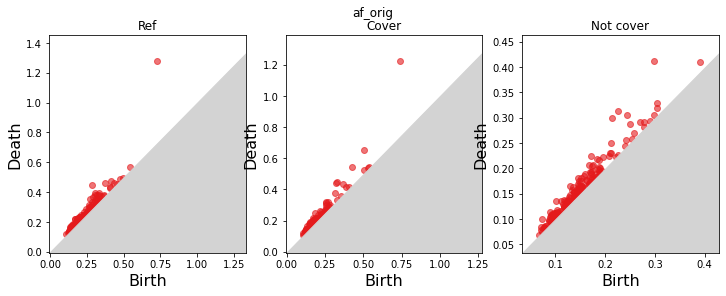

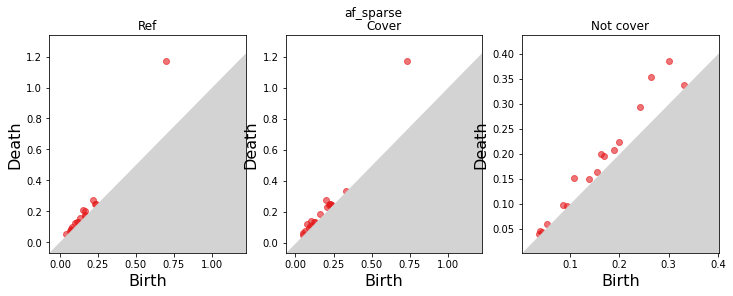

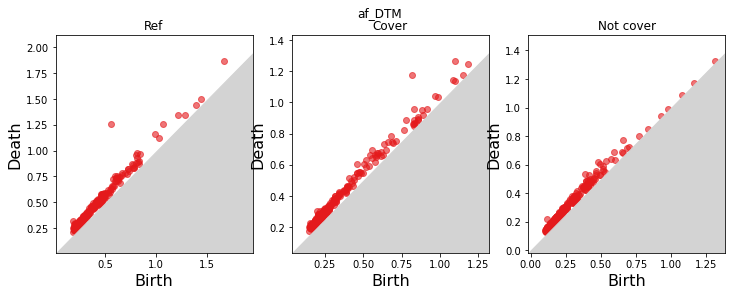

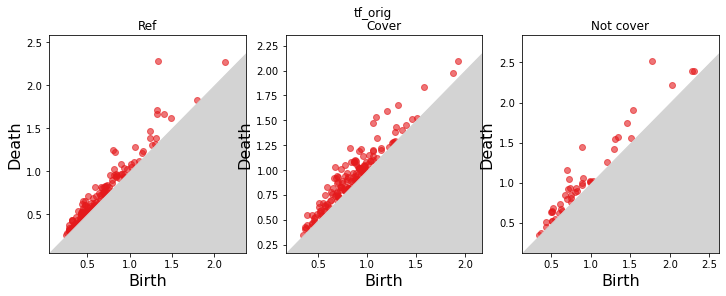

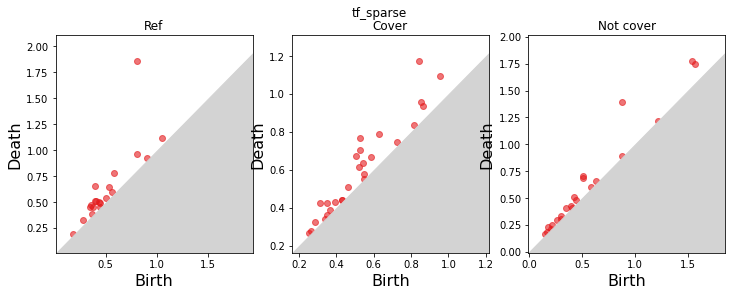

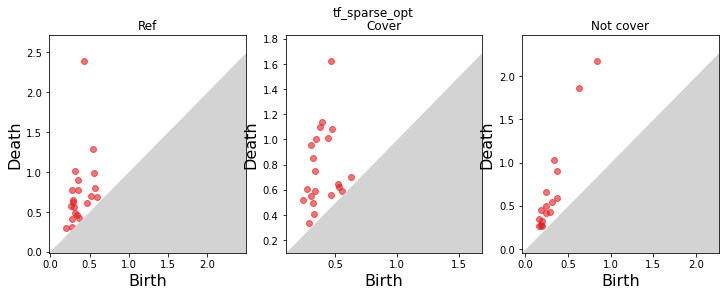

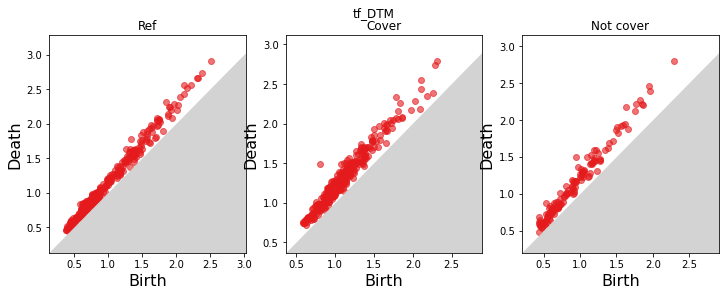

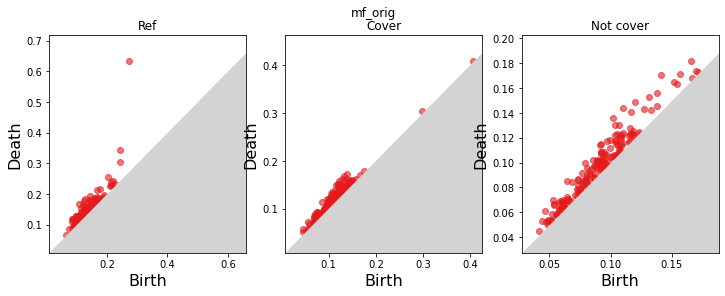

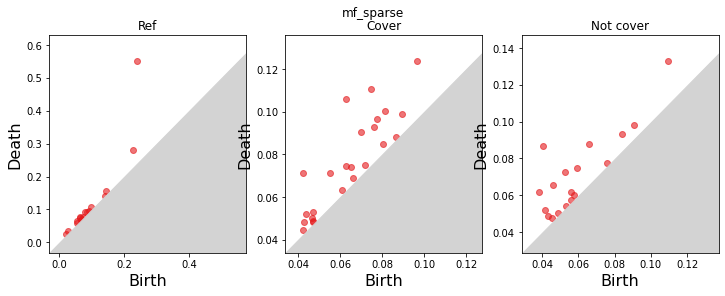

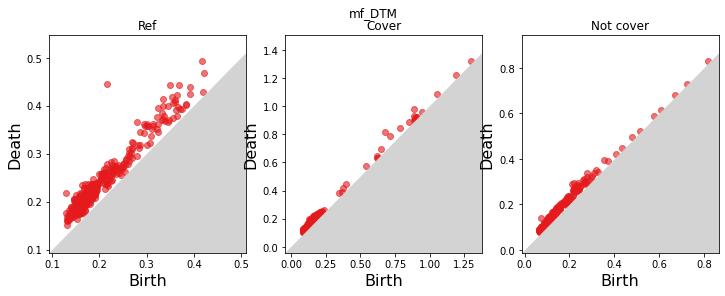

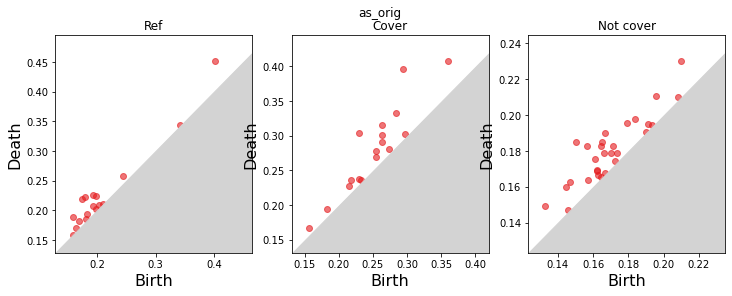

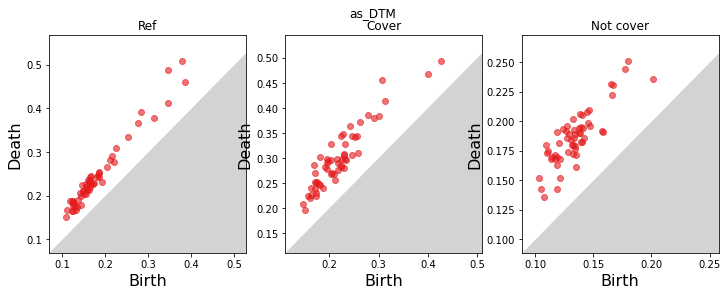

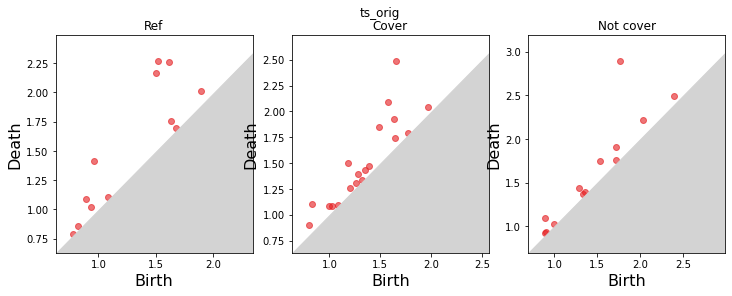

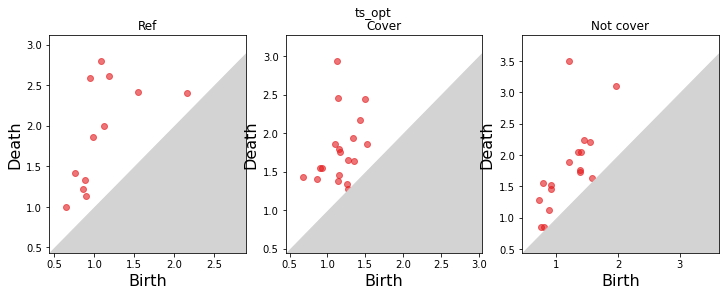

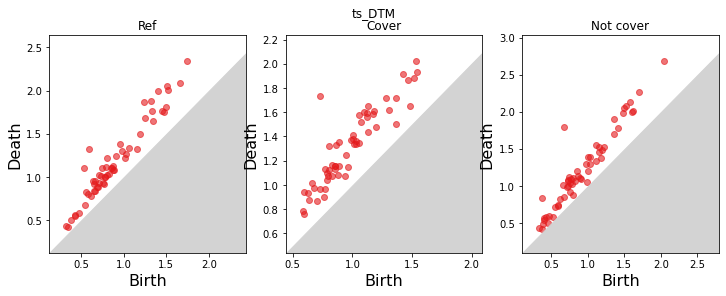

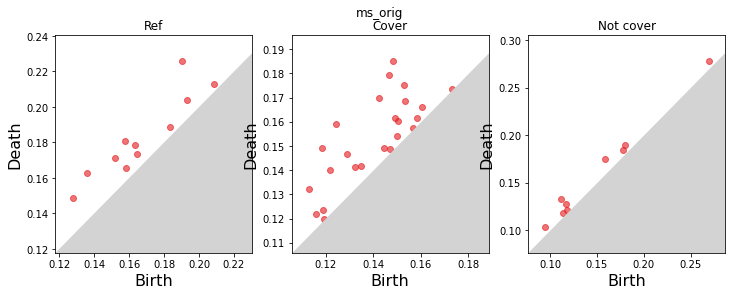

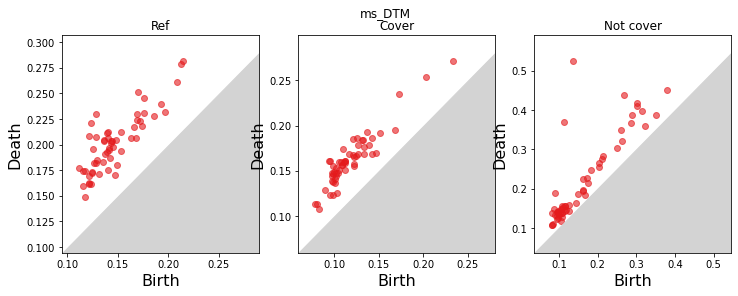

In [ ]:
#plotting persistence diagrams with 17 different customizations for 3 songs
#REF - COVER - NOT COVER
for name, df in df_mod_dict.items():
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

  if 'DTM' in name:
    arr1 = np.array(df.iloc[0,1])[:-1]
    arr2 = np.array(df.iloc[1,1])[:-1]
    arr3 = np.array(df.iloc[2,1])[:-1]
  else:
    arr1 = np.array(df.iloc[0,1])
    arr2 = np.array(df.iloc[1,1])
    arr3 = np.array(df.iloc[2,1])
  pers1 = [arr1]
  pers2 = [arr2]
  pers3 = [arr3]
  gd.plot_persistence_diagram(pers1[0], axes=ax1)
  gd.plot_persistence_diagram(pers2[0], axes=ax2)
  gd.plot_persistence_diagram(pers3[0], axes=ax3)
  ax1.set_title('Ref')
  ax2.set_title('Cover')
  ax3.set_title('Not cover')
  fig.suptitle(name)
  plt.show()


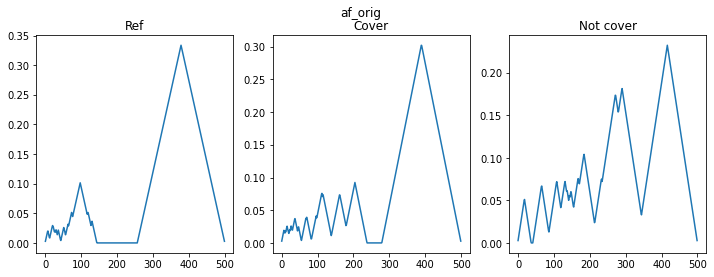

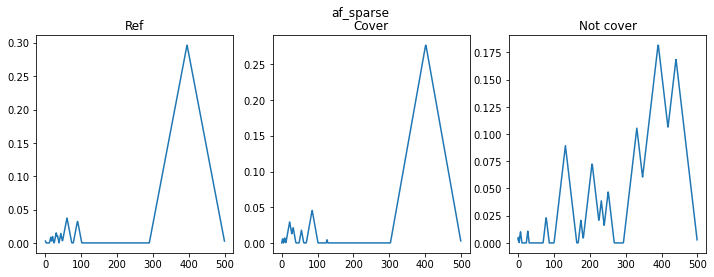

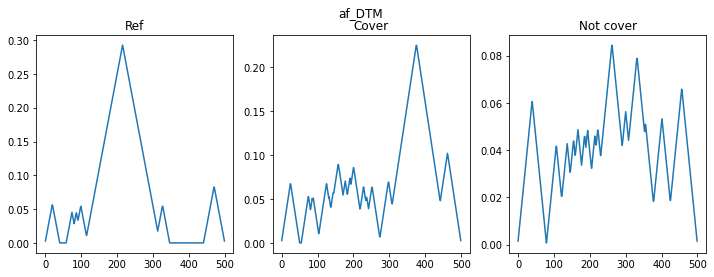

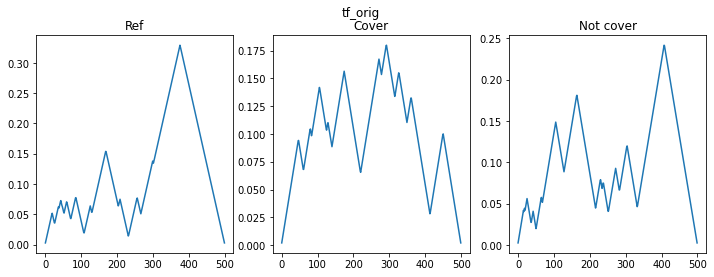

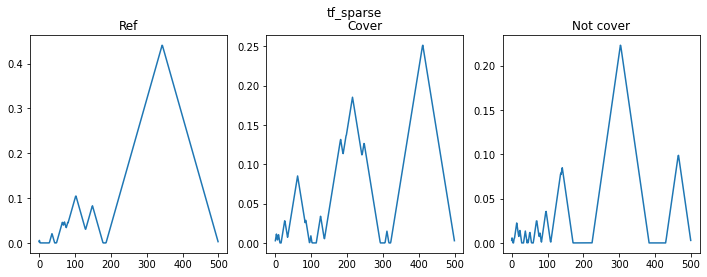

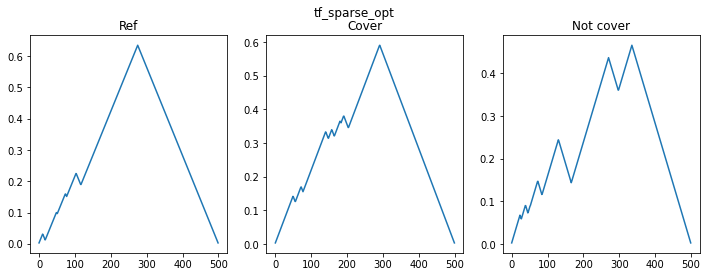

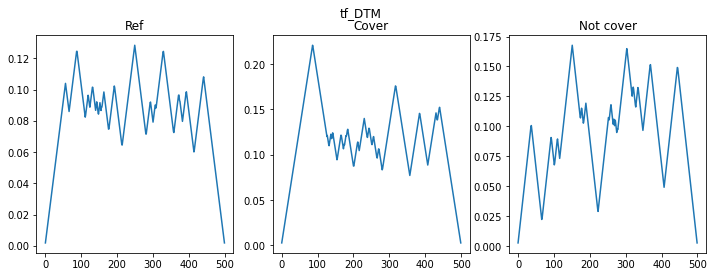

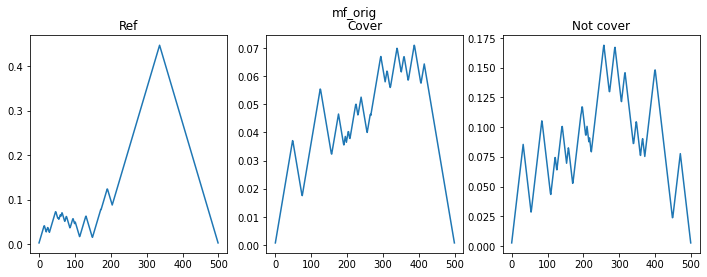

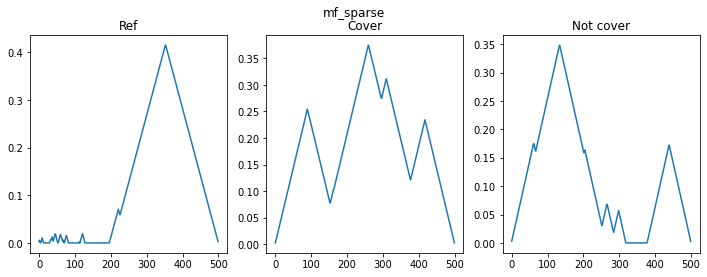

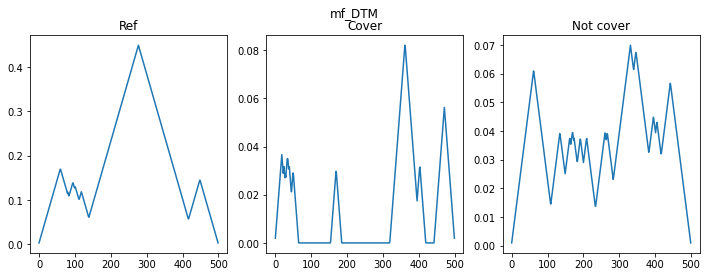

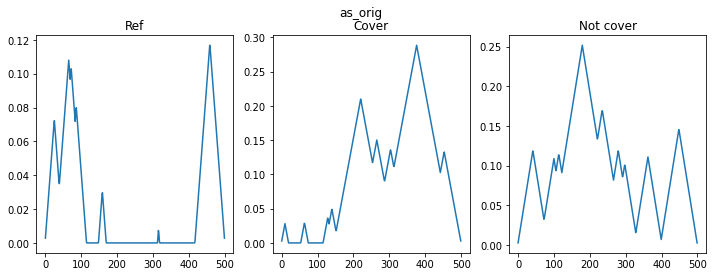

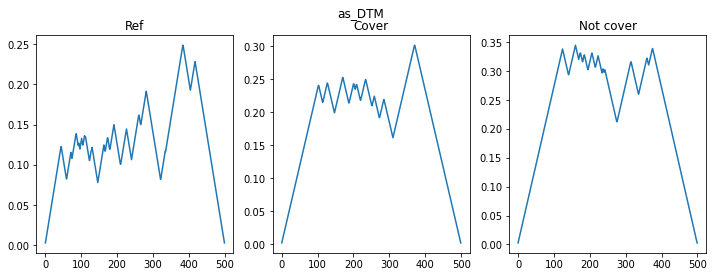

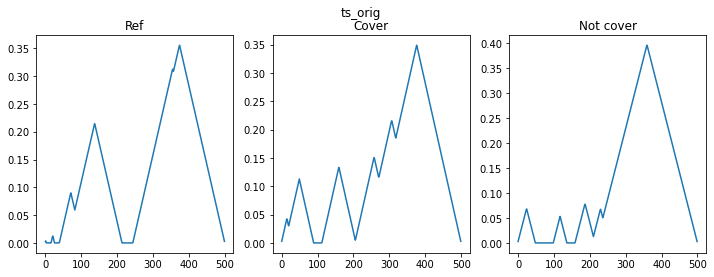

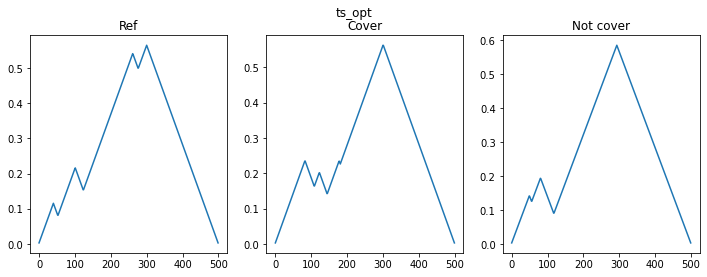

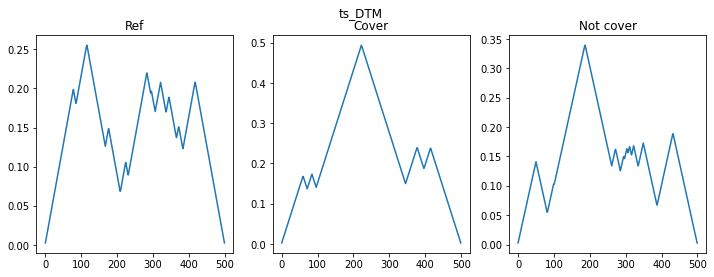

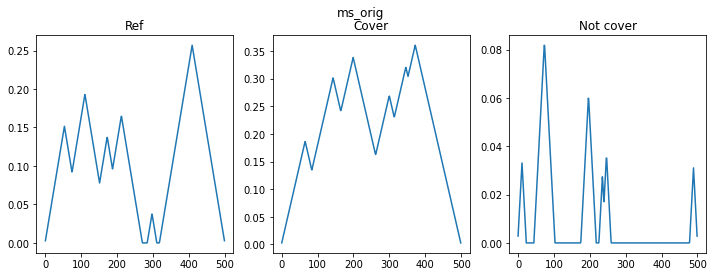

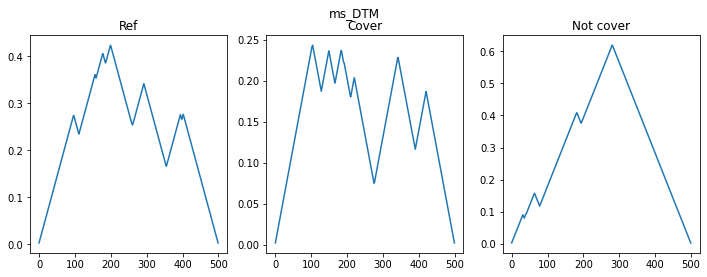

In [ ]:
#plotting landscapes with 17 different customizations for 3 songs
#REF - COVER - NOT COVER
for name, df in df_mod_dict.items():
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
  
  arr1 = df.iloc[0,2][0]
  arr2 = df.iloc[1,2][0]
  arr3 = df.iloc[2,2][0]
  ax1.plot(arr1)
  ax2.plot(arr2)
  ax3.plot(arr3)
  ax1.set_title('Ref')
  ax2.set_title('Cover')
  ax3.set_title('Not cover')
  fig.suptitle(name)
  plt.show()


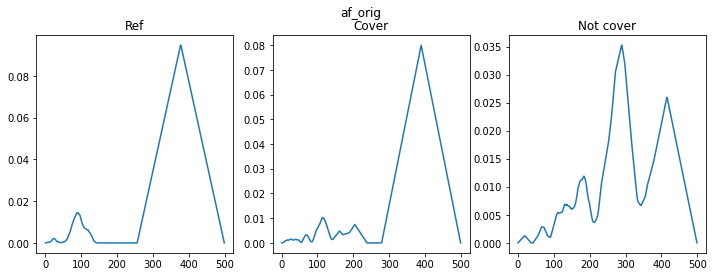

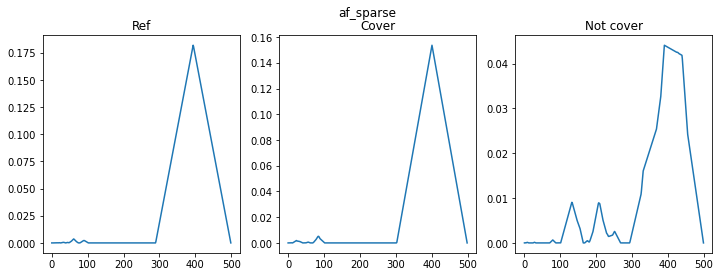

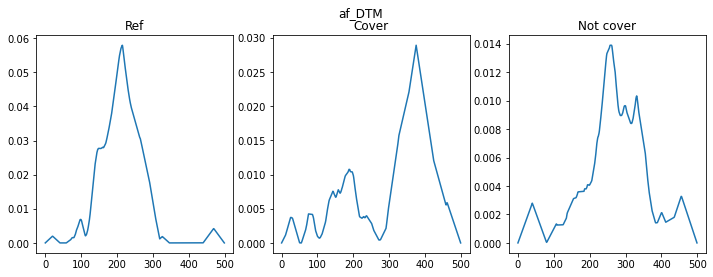

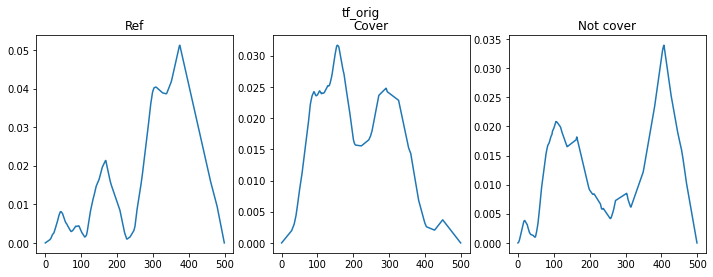

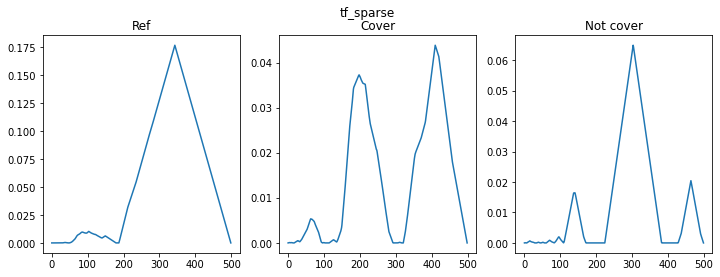

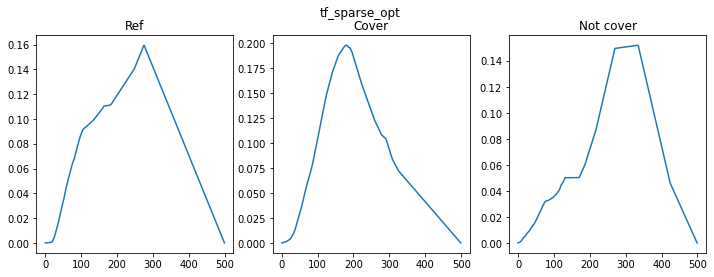

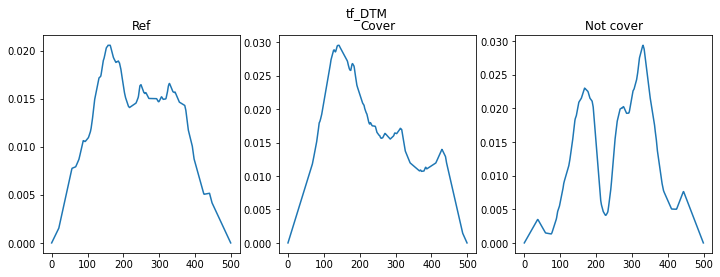

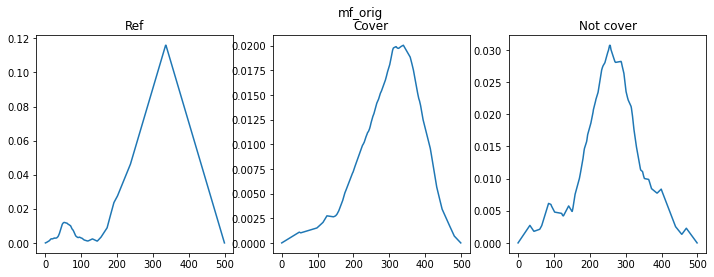

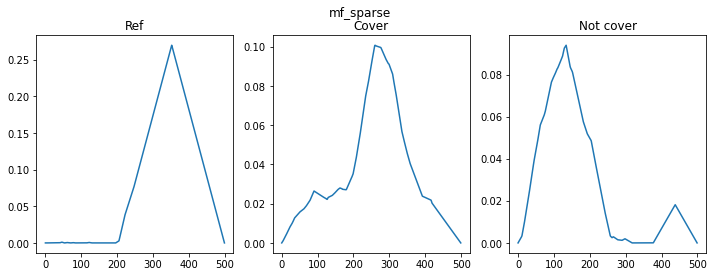

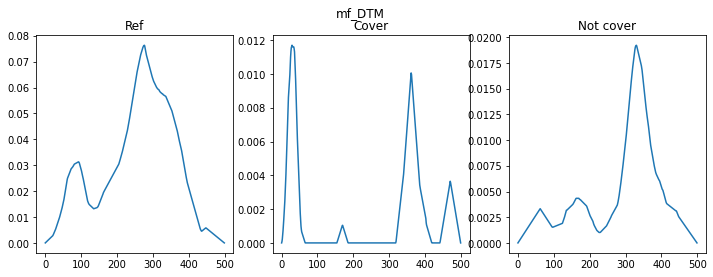

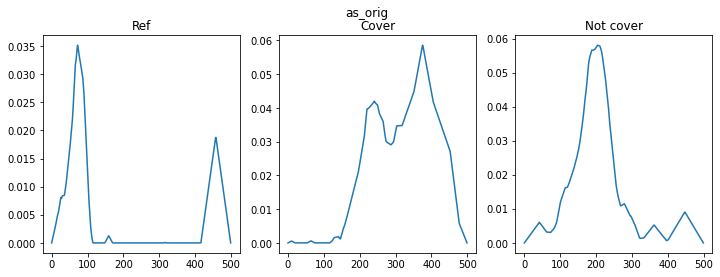

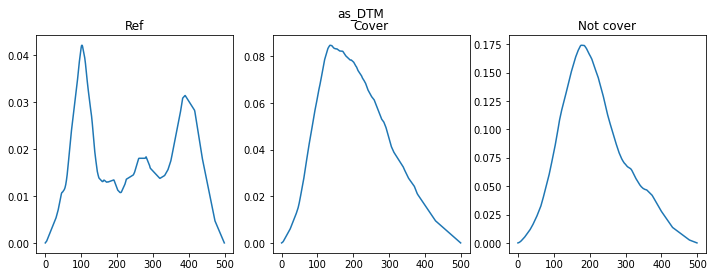

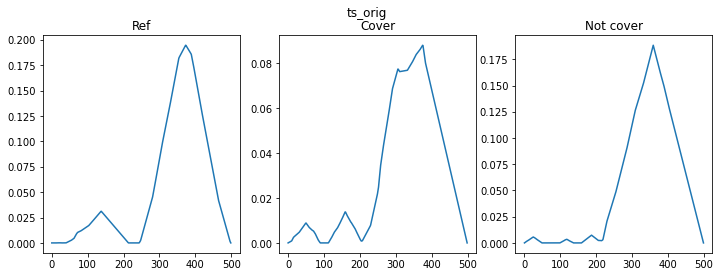

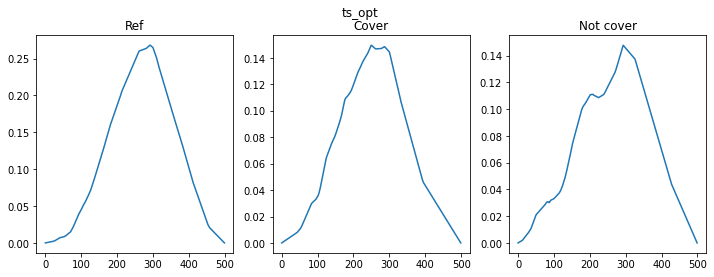

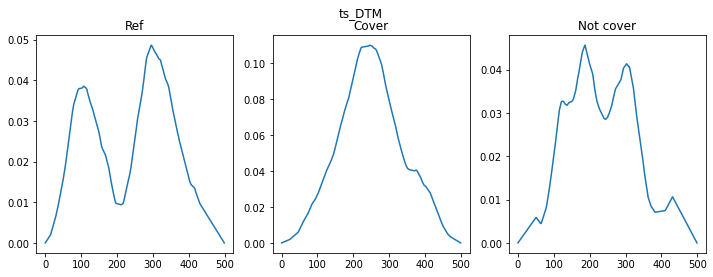

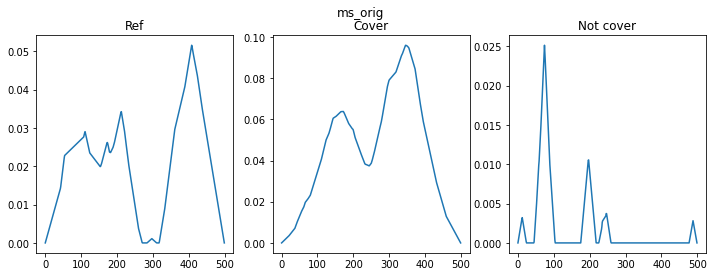

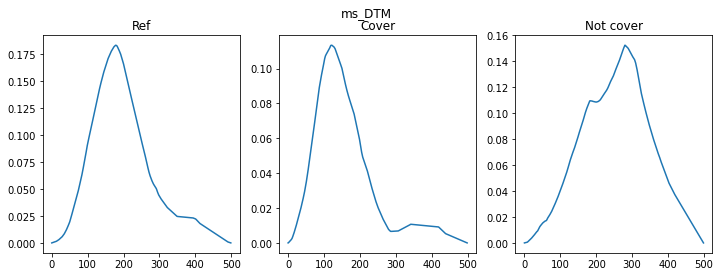

In [ ]:
#plotting silhouettes with 17 different customizations for 3 songs
#REF - COVER - NOT COVER
for name, df in df_mod_dict.items():
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
  
  arr1 = df.iloc[0,3][0]
  arr2 = df.iloc[1,3][0]
  arr3 = df.iloc[2,3][0]
  ax1.plot(arr1)
  ax2.plot(arr2)
  ax3.plot(arr3)
  ax1.set_title('Ref')
  ax2.set_title('Cover')
  ax3.set_title('Not cover')
  fig.suptitle(name)
  plt.show()


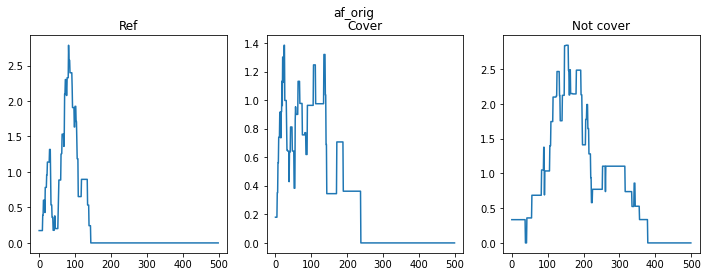

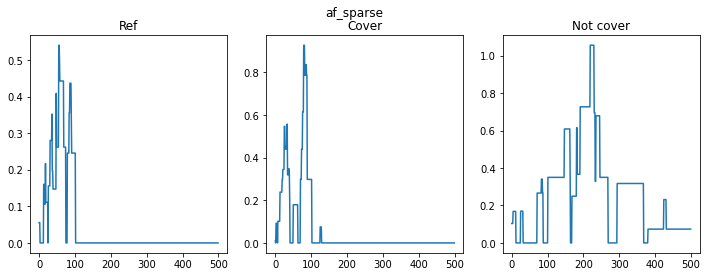

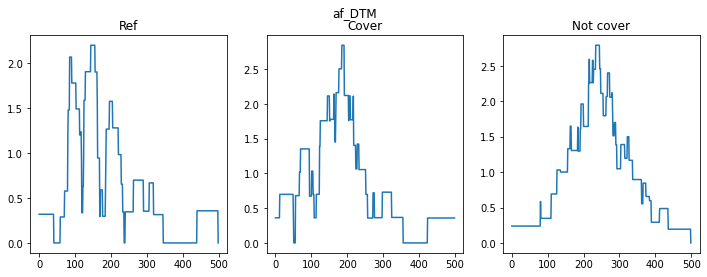

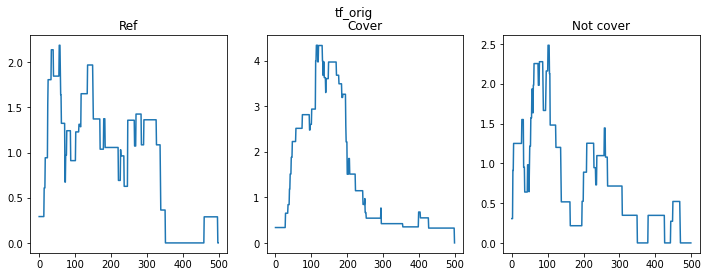

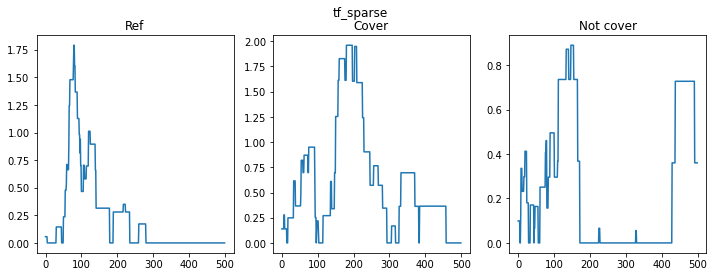

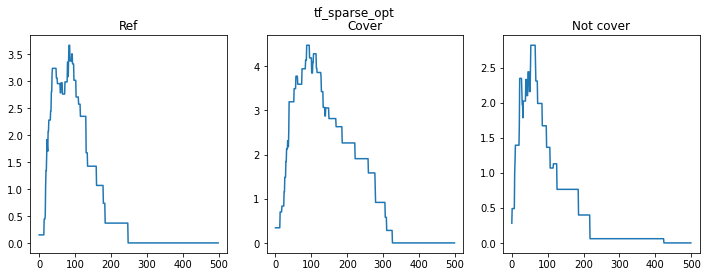

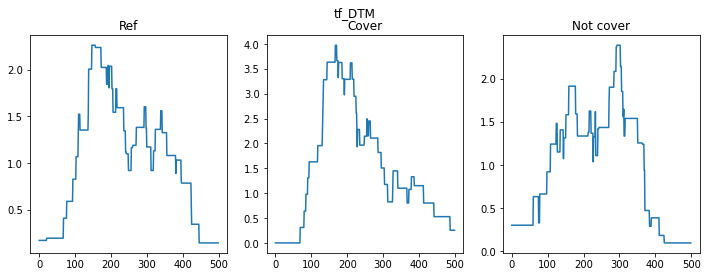

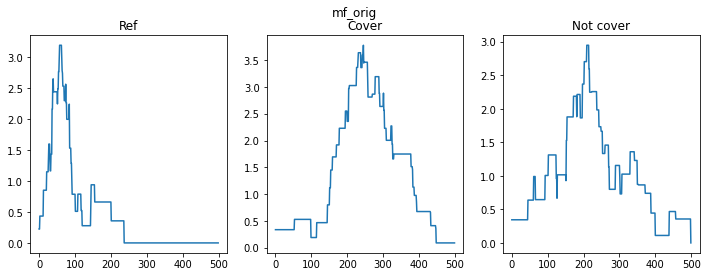

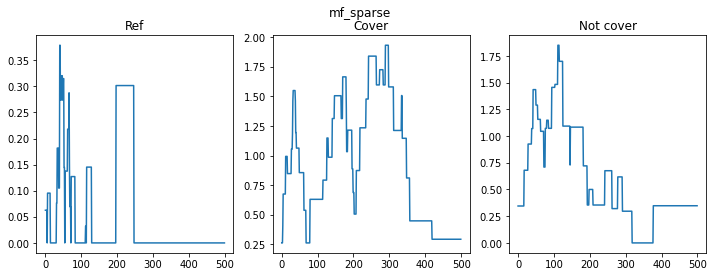

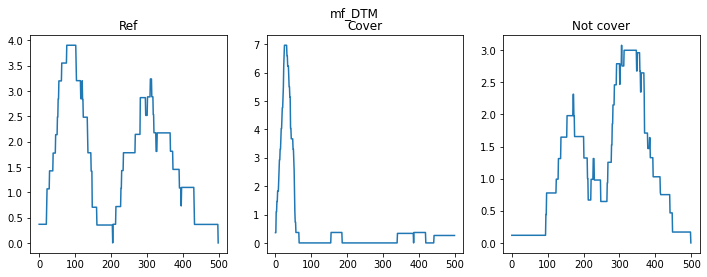

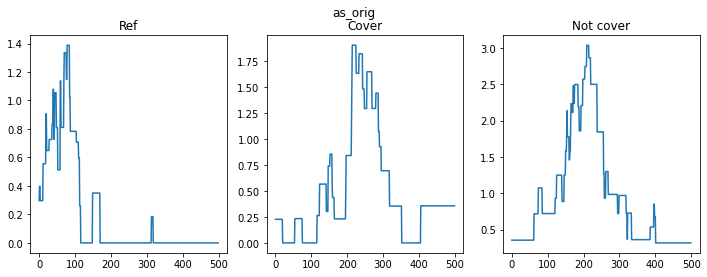

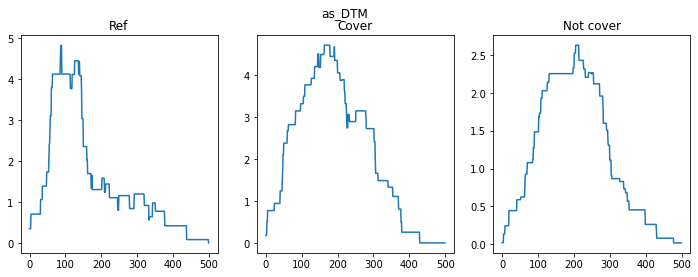

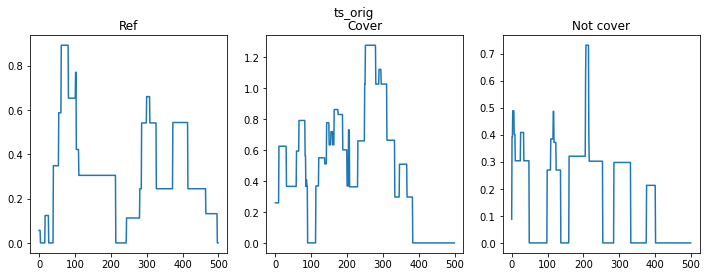

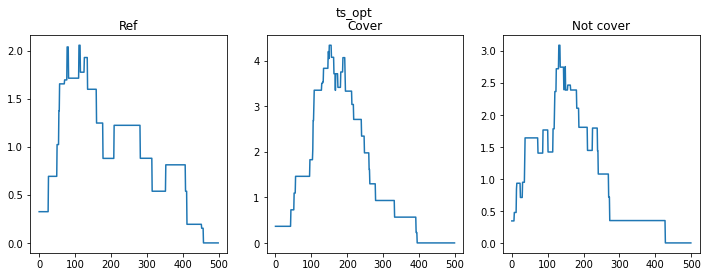

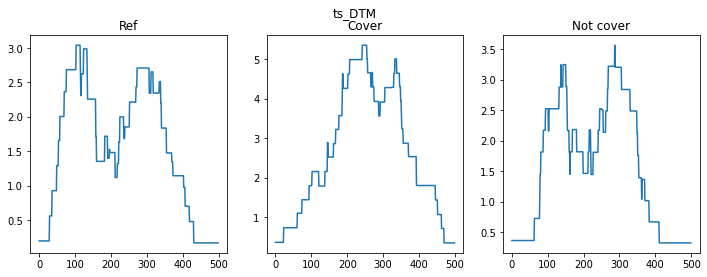

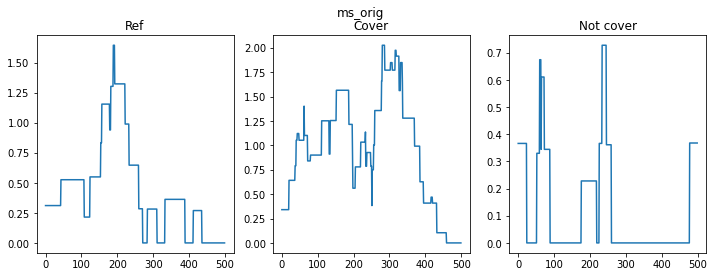

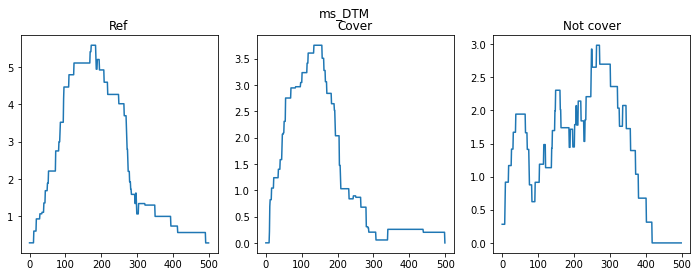

In [ ]:
#plotting entropies with 17 different customizations for 3 songs
#REF - COVER - NOT COVER
for name, df in df_mod_dict.items():
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
  
  arr1 = df.iloc[0,4][0]
  arr2 = df.iloc[1,4][0]
  arr3 = df.iloc[2,4][0]
  ax1.plot(arr1)
  ax2.plot(arr2)
  ax3.plot(arr3)
  ax1.set_title('Ref')
  ax2.set_title('Cover')
  ax3.set_title('Not cover')
  fig.suptitle(name)
  plt.show()


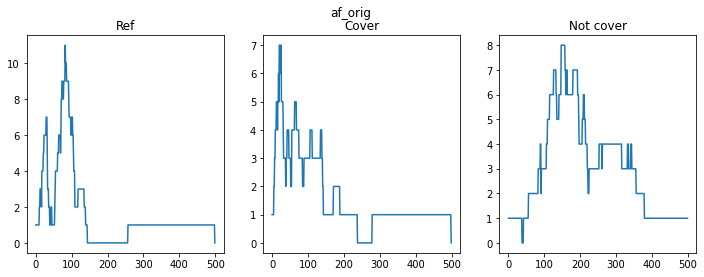

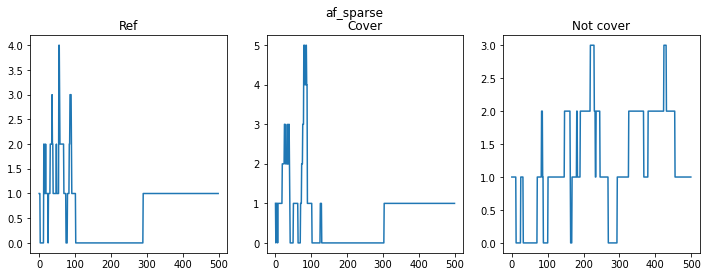

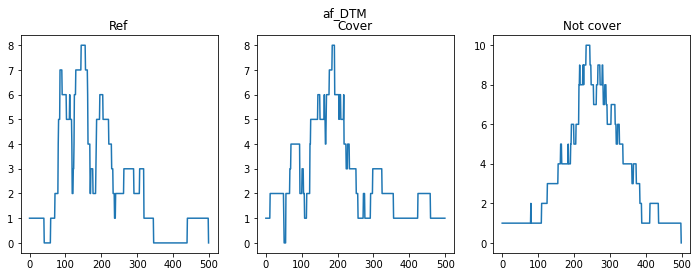

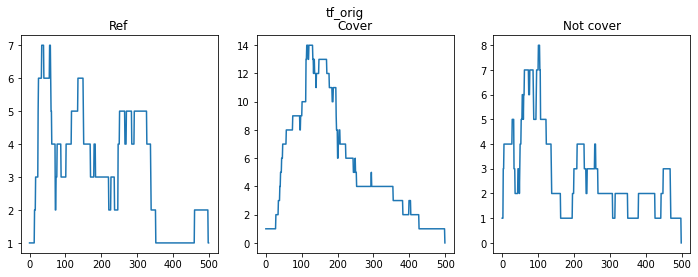

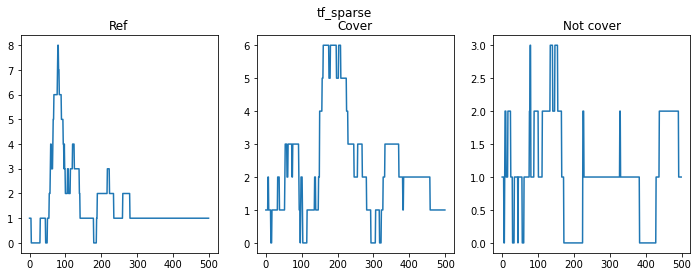

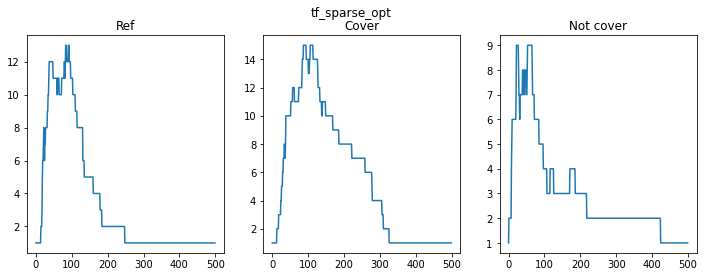

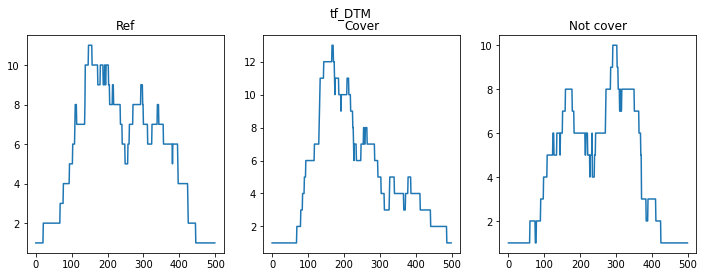

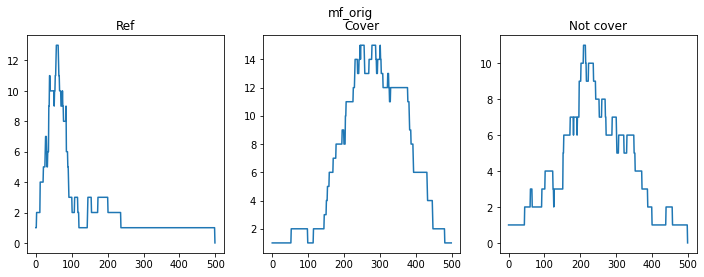

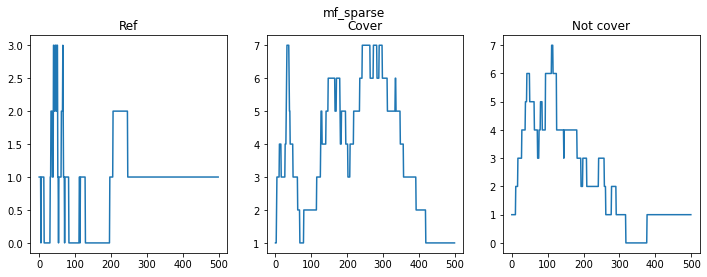

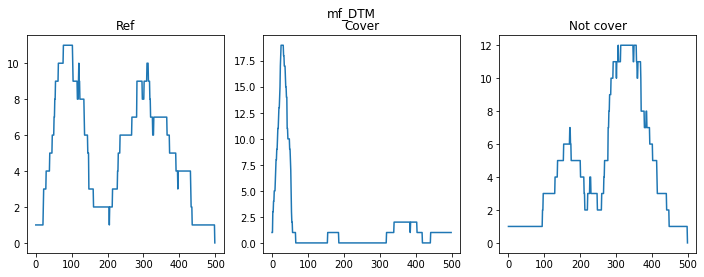

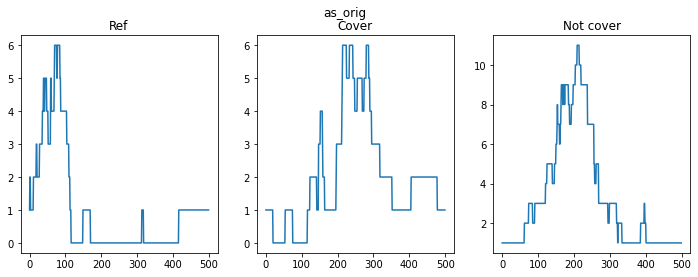

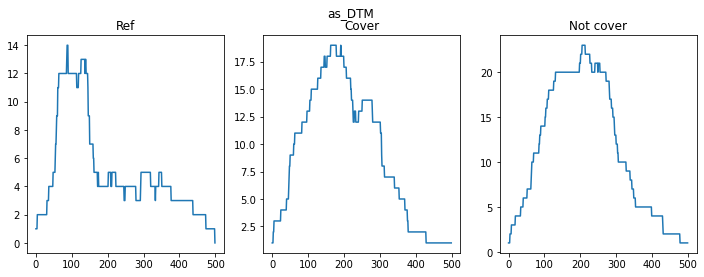

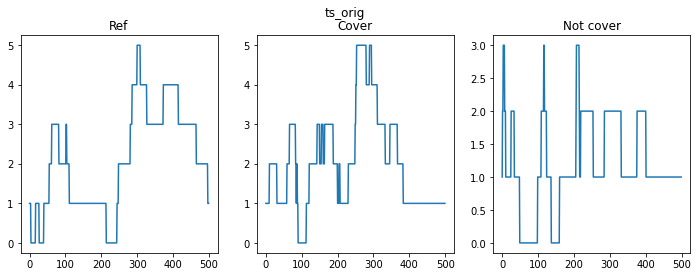

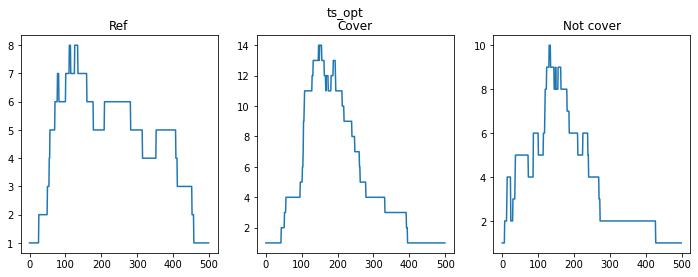

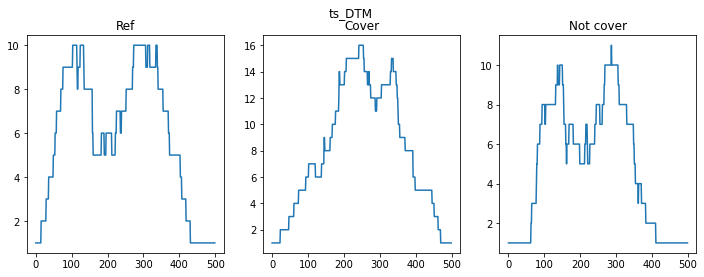

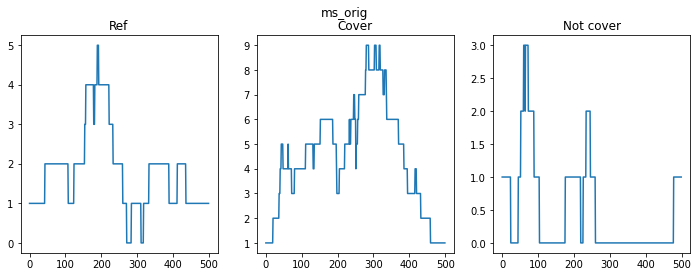

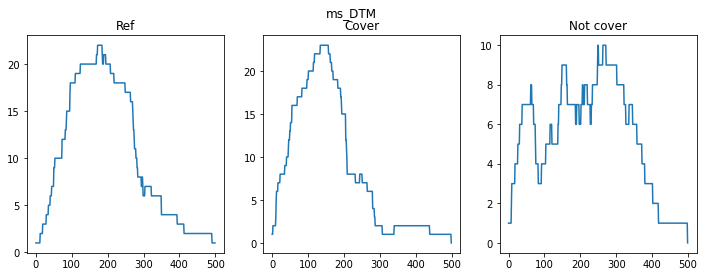

In [ ]:
#plotting betti_curves with 17 different customizations for 3 songs
#REF - COVER - NOT COVER
for name, df in df_mod_dict.items():
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
  
  arr1 = df.iloc[0,5][0]
  arr2 = df.iloc[1,5][0]
  arr3 = df.iloc[2,5][0]
  ax1.plot(arr1)
  ax2.plot(arr2)
  ax3.plot(arr3)
  ax1.set_title('Ref')
  ax2.set_title('Cover')
  ax3.set_title('Not cover')
  fig.suptitle(name)
  plt.show()
